In [1]:
import os
os.chdir('..')

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from skimage.draw import polygon
import xml.etree.ElementTree as ET
import numpy as np
from fastai.vision import *
import json

## Download and unzip data

In [4]:
path = Path.cwd(); path
data_path = path / 'data'

In [136]:
# TODO - Setup data/ dir structure
# Dir structure
# data
# --> raw_data/
# ---> --> xml_files
# ---> ---> image_files
# ---> task1_train - original + gen data
# ---> task1_masks - original + gen masks

In [5]:
# ! rm -rf {data_path / 'raw_data' / 'image_files'}
! rm -r {data_path / 'task1_train'}
! rm -r {data_path / 'task1_masks'}

In [6]:
# (path / 'data' / 'raw_data').mkdir(parents=True, exist_ok=True)
# (path / 'data' / 'raw_data' / 'xml_files').mkdir(parents=True, exist_ok=True)
# (path / 'data' / 'raw_data' / 'image_files').mkdir(parents=True, exist_ok=True)
# (path / 'data' / 'raw_data' / 'json_files').mkdir(parents=True, exist_ok=True)
(path / 'data' / 'task1' / 'images').mkdir(parents=True, exist_ok=True)
(path / 'data' / 'task1' / 'masks').mkdir(parents=True, exist_ok=True)

In [9]:
(path / 'data').ls()

[PosixPath('/home/jupyter/RASM2019/data/task1_train'),
 PosixPath('/home/jupyter/RASM2019/data/task1_masks'),
 PosixPath('/home/jupyter/RASM2019/data/raw_data')]

In [47]:
# Download training set
! wget -q -P {data_path / 'raw_data'} "https://www.dropbox.com/s/plw0b1cm31np24n/RASM2019_Example_Set.zip"

In [48]:
(data_path / 'raw_data').ls()

[PosixPath('/home/jupyter/RASM2019/data/raw_data/xml_files'),
 PosixPath('/home/jupyter/RASM2019/data/raw_data/image_files'),
 PosixPath('/home/jupyter/RASM2019/data/raw_data/RASM2019_Example_Set.zip')]

In [50]:
# Unzip training set
! unzip -q {data_path / 'raw_data' / 'RASM2019_Example_Set.zip'} -d {data_path / 'raw_data' / 'xml_files'}

In [51]:
tif_file_list = [file for file in (data_path / 'raw_data' / 'xml_files').ls() if file.suffix == '.tif']; len(tif_file_list)

20

In [52]:
# Move .tif files to raw_data/image_files/ dir
import shutil

for tif_file in tif_file_list:
    shutil.move(str(tif_file), str(data_path / 'raw_data' / 'image_files'))
#     shutil.copy(str(tif_file), str(data_path / 'task1_train'))

In [54]:
len((data_path / 'raw_data' / 'image_files').ls())

20

In [56]:
# copy image files to task1_train folder
tif_file_list = (data_path / 'raw_data' / 'image_files').ls()
for tif_file in tif_file_list:
    shutil.copy(str(tif_file), str((data_path / 'task1_train')))

In [58]:
len((data_path / 'task1_train').ls())

20

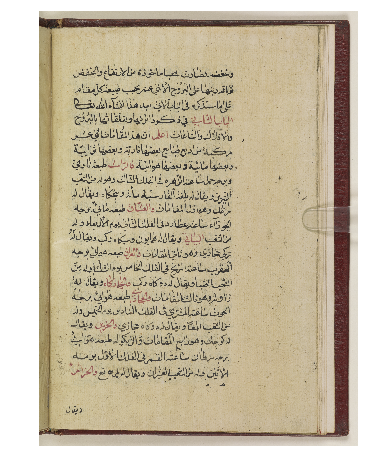

In [6]:
img_f = (data_path / 'task1_train' / 'Add MS 23494_0031.tif')
img = open_image(img_f)
img.show(figsize=(10, 8))

## Produce masks from xml ground truth and save as images

In [22]:
def parse_coords(points):
    return np.array([tuple(int(p) for p in point.split(',')) for point in points.split()])

# TODO - Save as JSON files to avoid precomputing every time
def load_xml_as_dict(path_to_file):
    tree = ET.parse(path_to_file)
    root = tree.getroot()
    SCHEMA = root.tag.split('PcGts')[0]
    metadata = root.find(f'{SCHEMA}Metadata')
    page = root.find(f'{SCHEMA}Page')
    image_info = page.attrib
    
    text_region_list = page.findall(f'{SCHEMA}TextRegion')
    text_region_data = []
    
    for text_region in text_region_list:
        text_region_id = text_region.attrib.get('id')
        text_region_type = text_region.attrib.get('type', 'page')
        text_region_coords = text_region.find(f'{SCHEMA}Coords').attrib.get('points')
        text_line_list = text_region.findall(f'{SCHEMA}TextLine')
        text_line_data = []
        
        for text_line in text_line_list:
            text_line_id = text_line.attrib['id']
            text_line_coords = text_line.find(f'{SCHEMA}Coords').attrib.get('points')
            text_line_text = text_line.find(f'{SCHEMA}TextEquiv')[0].text
            text_line_data.append({
                'id': text_line_id,
                'points': parse_coords(text_line_coords),
                'text': text_line_text
            })

        text_region_data.append({
            'id': text_region_id,
            'type': text_region_type,
            'points': parse_coords(text_region_coords),
            'lines': text_line_data
        })
        
    graphic_region_list = page.findall(f'{SCHEMA}GraphicRegion')
    graphic_region_data = []

    for graphic_region in graphic_region_list:
        graphic_region_id = graphic_region.attrib.get('id')
        graphic_region_coords = graphic_region.find(f'{SCHEMA}Coords').attrib.get('points')
        graphic_region_data.append({
            'id': graphic_region_id,
            'points': parse_coords(graphic_region_coords)
        })
        
    return image_info, text_region_data, graphic_region_data

class_labels = [
    'page',
    'paragraph',
    'marginalia',
    'caption',
    'graphic',
    'page-number',
    'other'
]

In [12]:
xml_dict = load_xml_as_dict(data_path / 'raw_data' / 'xml_files' / 'Or 13006_0042.xml')

In [23]:
def save_mask(mask, fn:PathOrStr):
    "Save the image to `fn`."
    x = image2np(mask.data).astype(np.uint8)
    PIL.Image.fromarray(x).save(fn)
    
def save_xml_as_json(xml_file_path):
    image_file_name = xml_file_path.stem
    print(image_file_name)
    image_info, text_region_data, graphic_region_data = load_xml_as_dict(xml_file_path)
    
    json_dict = {
        'image_info': image_info,
        'text_region_data': text_region_data,
        'graphic_region_data': graphic_region_data
    }
    
    with open(data_path / 'raw_data' / 'json_files'/ f'{image_file_name}.json', 'w') as f:
        json.dump(json_dict, f, indent=4)


def generate_mask(xml_file_path):
    image_file_name = xml_file_path.stem
    print(image_file_name)
    image_info, text_region_data, graphic_region_data = load_xml_as_dict(xml_file_path)
    im_height = int(image_info['imageHeight'])
    im_width = int(image_info['imageWidth'])
    labels = np.zeros((1, im_height, im_width), dtype=np.uint8)
    
    for text_region in text_region_data:
        points = text_region['points']
        region_type = text_region['type']
        rr, cc = polygon(points[:, 1], points[:, 0])
        labels[0, rr, cc] = class_labels.index(region_type)
        
    for graphic_region in graphic_region_data:
        points = graphic_region['points']
        rr, cc = polygon(points[:, 1], points[:, 0])
        labels[0, rr, cc] = class_labels.index('graphic')
        
    return ImageSegment(as_tensor(labels))

def generate_and_save_mask(xml_file_path):
    mask = generate_mask(xml_file_path)
    file_name = xml_file_path.stem
    save_mask(mask, (data_path / 'task1_masks'/ f'{file_name}_mask.png'))

In [24]:
# Number of images with ground truth for training
train_xml_files = [file for file in (data_path / 'raw_data' / 'xml_files').iterdir() if file.suffix == '.xml']; len(train_xml_files)

20

In [25]:
# # Parse xml data and save as json files
# from concurrent.futures import ProcessPoolExecutor

# with ProcessPoolExecutor() as executor:
#     executor.map(save_xml_as_json, train_xml_files)


Or 8349_0020
Or 8349_0019
Delhi Arabic 1901_0155
Add MS 7474_0032
Or 14791_0017
Or 5593_0083
Delhi Arabic 1901_0154
Or 5593_0033
Add MS 7474_0013
Add MS 7474_0043
Delhi Arabic 1901_0036
Or 13006_0042
Or 13006_0169
Or 5593_0034
Add MS 7474_0028
Add MS 7474_0042
Or 13006_0172
Or 3366_0111
Or 5593_0024
Add MS 23494_0031


In [10]:
# Generate masks and save them concurrently
from concurrent.futures import ProcessPoolExecutor

with ProcessPoolExecutor() as executor:
    executor.map(generate_and_save_mask, train_xml_files)

Add MS 7474_0032
Or 8349_0020
Or 5593_0083
Delhi Arabic 1901_0154
Or 14791_0017
Add MS 7474_0028
Delhi Arabic 1901_0155
Or 8349_0019
Or 5593_0033
Or 13006_0042
Delhi Arabic 1901_0036
Or 5593_0034
Add MS 7474_0042
Add MS 7474_0043
Or 13006_0169
Add MS 7474_0013
Or 3366_0111
Or 13006_0172
Or 5593_0024
Add MS 23494_0031


In [11]:
def show_image_with_mask(file_name):
    img = open_image(data_path / 'task1_train' /  f'{file_name}.tif')
    mask = open_mask(data_path / 'task1_masks' /  f'{file_name}_mask.png')
    img.show(y=mask, figsize=(10,9))

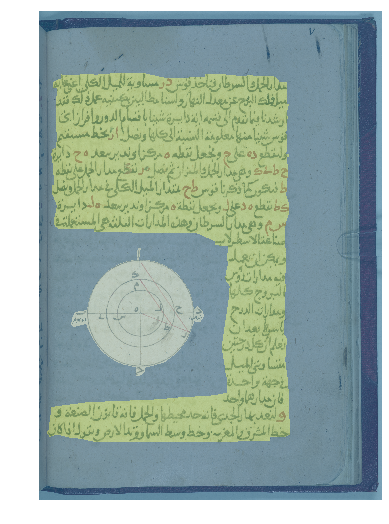

In [12]:
show_image_with_mask('Or 5593_0024')

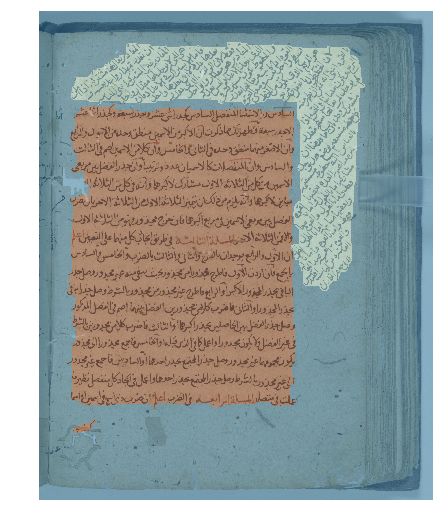

In [13]:
show_image_with_mask('Delhi Arabic 1901_0155')

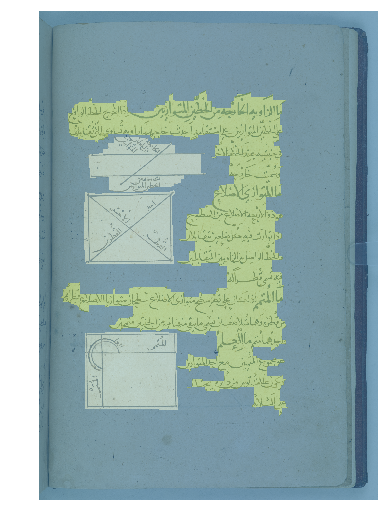

In [14]:
show_image_with_mask('Or 8349_0019')

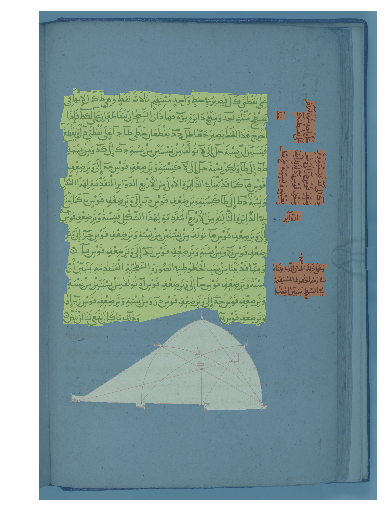

In [15]:
show_image_with_mask('Add MS 7474_0043')